### Import Section

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import matplotlib.cm as cm

ModuleNotFoundError: No module named 'matplotlib'

### Loading Data

In [ ]:
# Read data and display the first few rows

data=pd.read_csv("data/X_train.csv")

### Data View

In [ ]:
data.head()

,SeniorCitizen,tenure,MonthlyCharges,gender_Female,gender_Male,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year
0,0,1,60,0,1,0,1,0,1,1,0,1,0,0,0,1
1,0,30,55,1,0,1,0,0,1,1,0,1,0,0,1,0
2,1,46,100,1,0,1,0,0,1,0,1,0,1,1,0,0
3,0,43,66,0,1,1,0,0,1,1,0,1,0,0,1,0
4,0,1,20,0,1,1,0,0,1,0,1,0,1,0,0,1


### Data Normalization

In [ ]:
#Convert dataframe format to NumPy format
X=data.values

#data normalization
x_mean=X.mean(axis=0)
x_std=X.std(axis=0)
X=(X-x_mean)/x_std

### PCA Dimensionality Reduction

In [ ]:
#PCA Dimensionality Reduction

pca=PCA(n_components=2,random_state=0)
pca.fit(X)
X_pca=pca.transform(X)

### Elbow method 

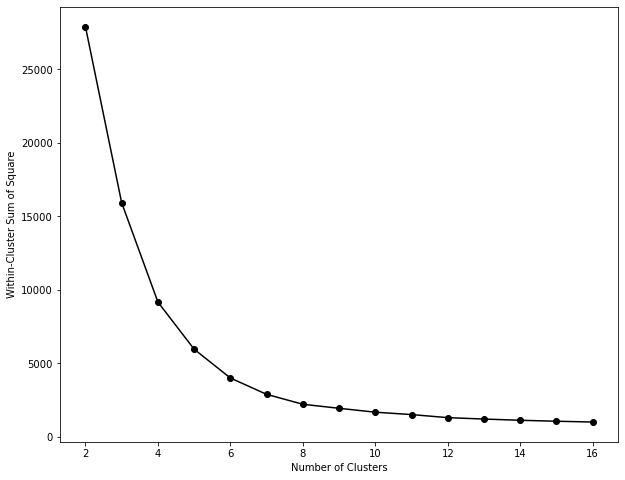

In [ ]:
#Elbow method for determining the optimal number of clusters

cs = []
k_list=np.array(list(range(1,16)))
for k in k_list:
    kmeans = KMeans(n_clusters = k, 
                    init = 'k-means++', 
                    max_iter = 300, 
                    n_init = 10, 
                    random_state = 0)
    kmeans.fit(X_pca)
    cs.append(kmeans.inertia_)
plt.figure(figsize=(10,8))
plt.plot(k_list+1, cs,'ko-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Square')
plt.savefig("results/Elbow.png",dpi=500,bbox_inches='tight')
plt.show()

### Clusters

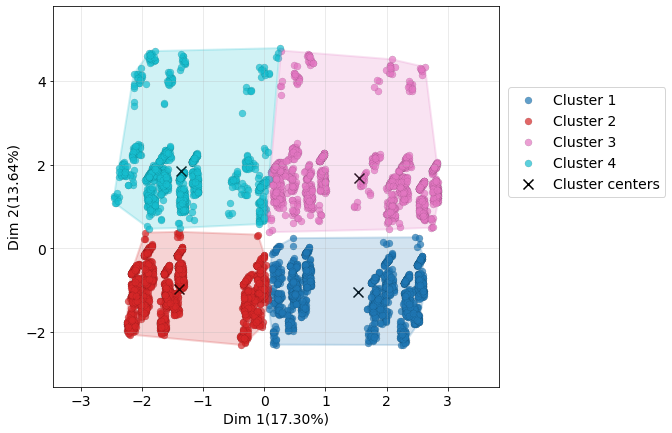

In [ ]:
K=4
kmeans=KMeans(n_clusters=K,random_state=0)
kmeans.fit(X_pca)
labels=kmeans.labels_
cluster_centers=kmeans.cluster_centers_

#Create graphics
plt.figure(figsize=(8, 7))
colors = cm.tab10(np.linspace(0, 1, K))


for i in range(K):
    # Draw scatter plots and convex hulls for each cluster.
    cluster_points = X_pca[labels == i]
    
    # Draw a scatter plot
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                c=[colors[i]], s=50, alpha=0.7, 
                label=f'Cluster {i+1}', edgecolors='black', linewidth=0.1)
    
    if len(cluster_points) >= 3:  # The convex hull needs at least 3 points.
        hull = ConvexHull(cluster_points)
        
        # Get the coordinates of the convex hull vertex
        hull_points = cluster_points[hull.vertices]
        
        # Create a polygon and fill it with a light color
        polygon = Polygon(hull_points, closed=True, 
                         facecolor=colors[i], alpha=0.2, 
                         edgecolor=colors[i], linewidth=2)
        plt.gca().add_patch(polygon)

plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
            marker='x',s=100,c='k',
            label="Cluster centers",)
    

# Add legend and title
plt.legend(loc=(1.02,0.5),fontsize=14)

plt.xlabel('Dim 1({:.2f}%)'.format(100*pca.explained_variance_ratio_[0]), fontsize=14)
plt.ylabel('Dim 2({:.2f}%)'.format(100*pca.explained_variance_ratio_[1]), fontsize=14)
plt.grid(True, alpha=0.3)

# Set axis range
plt.xlim(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1)
plt.ylim(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("results/Cluster_scatter_plot.png", dpi=500, bbox_inches='tight')
plt.show()

### Save Data

In [ ]:
#Preserve the Noise Center
cluster_centers=pca.inverse_transform(cluster_centers)
cluster_centers=cluster_centers*x_std+x_mean
centers_df=pd.DataFrame(cluster_centers,columns=data.columns,
                        index=["Clsuter {}".format(i+1) for i in range(K)])
centers_df.to_excel("results/cluster_center.xlsx")

#Save cluster labels
labels_df=data.copy()
labels_df["label"]=labels+1
labels_df.to_excel("results/cluster_label.xlsx", index=False)
#Save the clustering summary results
results_df=pd.DataFrame({"Cluster category":["cluster_{}".format(k+1) for k in range(K)],
                         "Frequency":[sum(labels==k) for k in range(K)],
                         "percentage(%)":["{:.2f}%".format(100*x/len(labels)) for x in [sum(labels==k) for k in range(K)]]})
results_df.to_excel("results/Clustering_results.xlsx", index=False)
results_df

,Cluster category,Frequency,percentage(%)
0,cluster_1,1609,28.56%
1,cluster_2,1971,34.98%
2,cluster_3,1060,18.81%
3,cluster_4,994,17.64%
